# Load data

In [1]:
from collections import namedtuple
Deletion = namedtuple('Deletion', ['family', 'chrom', 
                                   'start_pos', 'end_pos', 'start_index', 'end_index', 'length',
                                   'individuals',
                                   'doubledel', 'singledel', 'nodel',
                                   'mat_del', 'pat_del',
                                   'no_mat_del', 'no_pat_del',
                                   'mom_del', 'dad_del'])


In [2]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [3]:
chrom = '22'
family_sizes = [3, 4, 5, 6, 7]
phase_dir = '../sherlock_phased'
data_dir = '../split_gen_miss'

In [4]:
# Pull cytogenetic coordinates
with open('../data/cytoBand.txt', 'r') as f:
    xticks, xticklabels = [], []
    for line in f:
        pieces = line.strip().split()
        if pieces[0] == 'chr%s' % chrom:
            xticks.append(int(pieces[1]))
            xticklabels.append(pieces[3])

In [5]:
import numpy as np
clean_file = '%s/clean_indices_%s.txt' % (data_dir, chrom) 
snp_indices = []
snp_positions = []
with open(clean_file, 'r') as f:
    for i, line in enumerate(f):
        index, position = line.strip().split('\t')
        snp_indices.append(int(index))
        snp_positions.append(int(position))
snp_positions = np.array(snp_positions)
pos_to_index = dict([(p, i) for i, p in enumerate(snp_positions)])
max_index = snp_positions.shape[0]


In [6]:
from collections import defaultdict

# load deletions from all chromosomes
deletions = []
family_to_individuals = dict()

fams = set()
for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        num_fams_of_size = 0
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            family_to_individuals[family_key] = pieces[1:(1+j)]
            fams.add(family_key)
            num_fams_of_size += 1
        print('%d families of size %d' % (num_fams_of_size, j))
                
    # load deletions
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [int(x) for x in pieces[1:(1+(j*2))]]
            start_pos, end_pos = [int(x) for x in pieces[(1+(j*2)):(3+(j*2))]]
            start_index, end_index = pos_to_index[start_pos], pos_to_index[end_pos]
            length = end_pos - start_pos + 1
            individuals = family_to_individuals[family_key]    
            
            # if a parental chromosome isn't inherited, we actually don't know whether or not it has a deletion
            was_inh = [False, False, False, False]
            for k, child_id in enumerate(individuals[2:]):
                mat, pat = inheritance_state[(4+(2*k)):(6+(2*k))]
                was_inh[mat] = True
                was_inh[2+pat] = True
            for i in range(4):
                if not was_inh[i]:
                    inheritance_state[i] = -1
                
            doubledel, singledel, nodel = [], [], []
            has_mat_del, has_pat_del = [], []
            no_mat_del, no_pat_del = [], []

            # children
            for k, child_id in enumerate(individuals[2:]):
                mat, pat = inheritance_state[(4+(2*k)):(6+(2*k))]
                
                mat_del, pat_del = None, None
                if mat >= 0 and inheritance_state[mat] >= 0:
                    mat_del = inheritance_state[mat]==1
                elif mat == -1 and inheritance_state[0] == inheritance_state[1] and inheritance_state[0] >= 0:
                    mat_del = inheritance_state[0]==1
                    
                if pat >= 0 and inheritance_state[2+pat] >= 0:
                    pat_del = inheritance_state[2+pat]==1
                elif pat == -1 and inheritance_state[2] == inheritance_state[3] and inheritance_state[2] >= 0:
                    pat_del = inheritance_state[2]==1
                    
                if mat_del is not None and pat_del is not None:
                    if mat_del and pat_del:
                        doubledel.append(child_id)
                    elif mat_del or pat_del:
                        singledel.append(child_id)
                    else:
                        nodel.append(child_id)
                        
                if mat_del is not None:
                    if mat_del:
                        has_mat_del.append(child_id)
                    else:
                        no_mat_del.append(child_id)
                        
                if pat_del is not None:
                    if pat_del:
                        has_pat_del.append(child_id)
                    else:
                        no_pat_del.append(child_id)
                    
            # decide how many deletions mom and dad have
            mom_del, dad_del = None, None
            if inheritance_state[0] >= 0 and inheritance_state[1] >= 0:
                mom_del = inheritance_state[0]+inheritance_state[1]
            if inheritance_state[2] >= 0 and inheritance_state[3] >= 0:
                dad_del = inheritance_state[2]+inheritance_state[3]

            deletions.append(Deletion(family_key, chrom,
                                              start_pos, end_pos, start_index, end_index, length,
                                              individuals[:2]+doubledel+singledel+nodel,
                                              doubledel, singledel, nodel,
                                              has_mat_del, has_pat_del, no_mat_del, no_pat_del, 
                                              mom_del, dad_del))
        
                
print('Chrom', chrom, 'total families', len(fams))
                    
print('deletions', len(deletions), 
      'maternal', len([x for x in deletions if x.mom_del is not None and x.mom_del > 0]), 
      'paternal', len([x for x in deletions if x.dad_del is not None and x.dad_del > 0]))



18 families of size 3
436 families of size 4
357 families of size 5
56 families of size 6
6 families of size 7
Chrom 22 total families 873
deletions 364294 maternal 112384 paternal 121063


In [7]:
print('Maternal inheritance rate', sum([len(x.mat_del) for x in deletions if x.mom_del == 1])/sum([len(x.mat_del)+len(x.no_mat_del) for x in deletions if x.mom_del == 1]))
print('Paternal inheritance rate', sum([len(x.pat_del) for x in deletions if x.dad_del == 1])/sum([len(x.pat_del)+len(x.no_pat_del) for x in deletions if x.dad_del == 1]))
print()
print('Male Maternal inheritance rate', sum([len([y for y in x.mat_del if child_id_to_sex[y] == '1']) for x in deletions if x.mom_del == 1])/sum([len([y for y in x.mat_del if child_id_to_sex[y] == '1'])+len([y for y in x.no_mat_del if child_id_to_sex[y] == '1']) for x in deletions if x.mom_del == 1]))
print('Male Paternal inheritance rate', sum([len([y for y in x.pat_del if child_id_to_sex[y] == '1']) for x in deletions if x.dad_del == 1])/sum([len([y for y in x.pat_del if child_id_to_sex[y] == '1'])+len([y for y in x.no_pat_del if child_id_to_sex[y] == '1']) for x in deletions if x.dad_del == 1]))

print('Female Maternal inheritance rate', sum([len([y for y in x.mat_del if child_id_to_sex[y] == '2']) for x in deletions if x.mom_del == 1])/sum([len([y for y in x.mat_del if child_id_to_sex[y] == '2'])+len([y for y in x.no_mat_del if child_id_to_sex[y] == '2']) for x in deletions if x.mom_del == 1]))
print('Female Paternal inheritance rate', sum([len([y for y in x.pat_del if child_id_to_sex[y] == '2']) for x in deletions if x.dad_del == 1])/sum([len([y for y in x.pat_del if child_id_to_sex[y] == '2'])+len([y for y in x.no_pat_del if child_id_to_sex[y] == '2']) for x in deletions if x.dad_del == 1]))
print()
print('Autism Maternal inheritance rate', sum([len([y for y in x.mat_del if child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])/sum([len([y for y in x.mat_del if child_id_to_affected[y] == '2'])+len([y for y in x.no_mat_del if child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1]))
print('Autism Paternal inheritance rate', sum([len([y for y in x.pat_del if child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1])/sum([len([y for y in x.pat_del if child_id_to_affected[y] == '2'])+len([y for y in x.no_pat_del if child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1]))

print('Control Maternal inheritance rate', sum([len([y for y in x.mat_del if child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])/sum([len([y for y in x.mat_del if child_id_to_affected[y] == '1'])+len([y for y in x.no_mat_del if child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1]))
print('Control Paternal inheritance rate', sum([len([y for y in x.pat_del if child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1])/sum([len([y for y in x.pat_del if child_id_to_affected[y] == '1'])+len([y for y in x.no_pat_del if child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1]))


Maternal inheritance rate 0.4944338884542305
Paternal inheritance rate 0.49510767345041107

Male Maternal inheritance rate 0.49733866701930707
Male Paternal inheritance rate 0.4912560623054928
Female Maternal inheritance rate 0.4883688824463312
Female Paternal inheritance rate 0.5028879599195839

Autism Maternal inheritance rate 0.4915208093023922
Autism Paternal inheritance rate 0.49291515172109146
Control Maternal inheritance rate 0.50476335645149
Control Paternal inheritance rate 0.5027651847808028


# Analyze relationship between deletions and disease
We're going to look at both deletion status (DEL) as well as deletion transmission disequilibrium (TDT) and parental differences (PAR) as a baseline.

In [8]:
# Create contingency tables for each comparison

family_to_has_aff_and_unaff = dict()
for famkey, inds in family_to_individuals.items():
    has_aff_child = len([x for x in inds[2:] if child_id_to_affected[x] == '2']) > 0
    has_unaff_child = len([x for x in inds[2:] if child_id_to_affected[x] == '1']) > 0
    
    family_to_has_aff_and_unaff[famkey] = has_aff_child and has_unaff_child
    
print(sum(family_to_has_aff_and_unaff.values()), len(family_to_has_aff_and_unaff)-sum(family_to_has_aff_and_unaff.values()))

# position, has_del, is_affected, is_male, is_pat
# for del, only consider families with at least one affected and one unaffected child
del_conting_t = np.zeros((max_index+1, 2, 2, 2, 2), dtype=int)
tdt_conting_t = np.zeros((max_index+1, 2, 2, 2, 2), dtype=int)
par_conting_t = np.zeros((max_index+1, 3, 2), dtype=int)

for d in deletions:
    # DEL
    if family_to_has_aff_and_unaff[d.family]:
        for x in d.doubledel:
            is_male = int(child_id_to_sex[x] == '1')
            is_affected = int(child_id_to_affected[x] == '2')
            
            del_conting_t[d.start_index:(d.end_index+1), 1, is_affected, is_male, 0] += 1
            del_conting_t[d.start_index:(d.end_index+1), 1, is_affected, is_male, 1] += 1
        for x in d.singledel:
            is_male = int(child_id_to_sex[x] == '1')
            is_affected = int(child_id_to_affected[x] == '2')
            is_pat = int(x in d.pat_del)
            
            del_conting_t[d.start_index:(d.end_index+1), 1, is_affected, is_male, is_pat] += 1
            del_conting_t[d.start_index:(d.end_index+1), 0, is_affected, is_male, 1-is_pat] += 1
            
        for x in d.nodel:
            is_male = int(child_id_to_sex[x] == '1')
            is_affected = int(child_id_to_affected[x] == '2')
            
            del_conting_t[d.start_index:(d.end_index+1), 0, is_affected, is_male, 0] += 1
            del_conting_t[d.start_index:(d.end_index+1), 0, is_affected, is_male, 1] += 1
        
    # PAR
    if d.mom_del is not None:
        par_conting_t[d.start_index:(d.end_index+1), d.mom_del, 0] += 1
    if d.dad_del is not None:
        par_conting_t[d.start_index:(d.end_index+1), d.dad_del, 1] += 1
    
    # TDT
    if d.mom_del == 1:
        # mom
        for x in d.mat_del:
            is_male = int(child_id_to_sex[x] == '1')
            is_affected = int(child_id_to_affected[x] == '2')
            
            tdt_conting_t[d.start_index:(d.end_index+1), 1, is_affected, is_male, 0] += 1
        
        for x in d.no_mat_del:
            is_male = int(child_id_to_sex[x] == '1')
            is_affected = int(child_id_to_affected[x] == '2')
            
            tdt_conting_t[d.start_index:(d.end_index+1), 0, is_affected, is_male, 0] += 1
            
    if d.dad_del == 1:
        # dad
        for x in d.pat_del:
            is_male = int(child_id_to_sex[x] == '1')
            is_affected = int(child_id_to_affected[x] == '2')
            
            tdt_conting_t[d.start_index:(d.end_index+1), 1, is_affected, is_male, 1] += 1
        
        for x in d.no_pat_del:
            is_male = int(child_id_to_sex[x] == '1')
            is_affected = int(child_id_to_affected[x] == '2')
            
            tdt_conting_t[d.start_index:(d.end_index+1), 0, is_affected, is_male, 1] += 1
    
total_affected = sum([len([x for x in individuals[2:] if child_id_to_affected[x] == '2']) for individuals in family_to_individuals.values()])
total_unaffected = sum([len([x for x in individuals[2:] if child_id_to_affected[x] != '2']) for individuals in family_to_individuals.values()])
print('total affected', total_affected, 'total unaffected', total_unaffected)

total_families = len(family_to_individuals)
print('total families', total_families)


357 516
total affected 1827 total unaffected 388
total families 873


In [9]:
# find indices of changes
par_diff = np.sum(np.abs(par_conting_t[1:, :, :] - par_conting_t[:-1, :, :]), axis=(1, 2))
indices = np.where(par_diff>0)[0]
print(indices.shape)

(20703,)


In [10]:
from scipy.stats import chi2_contingency, fisher_exact

# calculate pvalues for every point
del_pvalues = np.ones((max_index+1,))
del_male_pvalues = np.ones((max_index+1,))
del_female_pvalues = np.ones((max_index+1,))
del_mat_pvalues = np.ones((max_index+1,))
del_pat_pvalues = np.ones((max_index+1,))

tdt_pvalues = np.ones((max_index+1,))
tdt_male_pvalues = np.ones((max_index+1,))
tdt_female_pvalues = np.ones((max_index+1,))
tdt_mat_pvalues = np.ones((max_index+1,))
tdt_pat_pvalues = np.ones((max_index+1,))

del_male_pat_pvalues = np.ones((max_index+1,))
del_male_mat_pvalues = np.ones((max_index+1,))
del_female_pat_pvalues = np.ones((max_index+1,))
del_female_mat_pvalues = np.ones((max_index+1,))

tdt_male_pat_pvalues = np.ones((max_index+1,))
tdt_male_mat_pvalues = np.ones((max_index+1,))
tdt_female_pat_pvalues = np.ones((max_index+1,))
tdt_female_mat_pvalues = np.ones((max_index+1,))

par_pvalues = np.ones((max_index+1,))

num_tests = 0

for dc_t, p in [(np.sum(del_conting_t, axis=(3, 4)), del_pvalues),
              (np.sum(del_conting_t, axis=4)[:, :, 0], del_female_pvalues),
              (np.sum(del_conting_t, axis=4)[:, :, 1], del_male_pvalues),
              (np.sum(del_conting_t, axis=3)[:, :, 0], del_mat_pvalues),
              (np.sum(del_conting_t, axis=3)[:, :, 1], del_pat_pvalues),
              (np.sum(tdt_conting_t, axis=(3, 4)), tdt_pvalues),
              (np.sum(tdt_conting_t, axis=4)[:, :, 0], tdt_female_pvalues),
              (np.sum(tdt_conting_t, axis=4)[:, :, 1], tdt_male_pvalues),
              (np.sum(tdt_conting_t, axis=3)[:, :, 0], tdt_mat_pvalues),
              (np.sum(tdt_conting_t, axis=3)[:, :, 1], tdt_pat_pvalues),
              (par_conting_t, par_pvalues),
              (del_conting_t[:, :, 0, 0], del_female_mat_pvalues),
              (del_conting_t[:, :, 0, 1], del_female_pat_pvalues),
              (del_conting_t[:, :, 1, 0], del_male_mat_pvalues),
              (del_conting_t[:, :, 1, 1], del_male_pat_pvalues),
              (tdt_conting_t[:, :, 0, 0], tdt_female_mat_pvalues),
              (tdt_conting_t[:, :, 0, 1], tdt_female_pat_pvalues),
              (tdt_conting_t[:, :, 1, 0], tdt_male_mat_pvalues),
              (tdt_conting_t[:, :, 1, 1], tdt_male_pat_pvalues),
             ]:
    prev_i = 0
    for i in indices:
        dc = dc_t[i, :, :]

        # get rid of 0 rows/columns
        dc = dc[np.ix_(np.all(dc>10, axis=1), np.all(dc>10, axis=0))]

        # calculate pvalue
        if dc.shape[0] > 1 and dc.shape[1] > 1:
            pvalue = chi2_contingency(dc, correction=False)[1]
            num_tests += 1
        #elif dc_t[i, :, :].shape == (2, 2):
        #    pvalue = fisher_exact(dc_t[i, :, :])[1]
        else:
            pvalue = 1
        p[prev_i:i] = pvalue
        prev_i = i
print(num_tests)

183812


del_male	28	16982758	16982786	q11.1
del_male	3725	16982880	16986605	q11.1
del_male	175	18716609	18716784	q11.21
del_male	11	18716796	18716807	q11.21
del_male	152	18716864	18717016	q11.21
del_male	17	18718200	18718217	q11.21
del_male	79	18718643	18718722	q11.21
del_male	130	18877833	18877963	q11.21
del_male	71	18880775	18880846	q11.21
del_male	1182	20151185	20152367	q11.21
del_male	8	20656904	20656912	q11.21
del_male	186	20668927	20669113	q11.21
del_male	26	20670088	20670114	q11.21
del_male	28	21518428	21518456	q11.21
del_male	389	42899436	42899825	q13.2
del_male	55	42899880	42899935	q13.2
del_female	2	18718215	18718217	q11.21
del_female	79	18718643	18718722	q11.21
del_female	48	18880798	18880846	q11.21
del_female	8	20656904	20656912	q11.21
tdt	153	18718498	18718651	q11.21
tdt	20	18718652	18718672	q11.21
tdt	40	18718682	18718722	q11.21
tdt	48	18880798	18880846	q11.21
tdt_male	19	18718196	18718215	q11.21
tdt_male	224	18718498	18718722	q11.21
tdt_male	130	18877833	18877963	q11.21
tdt_male

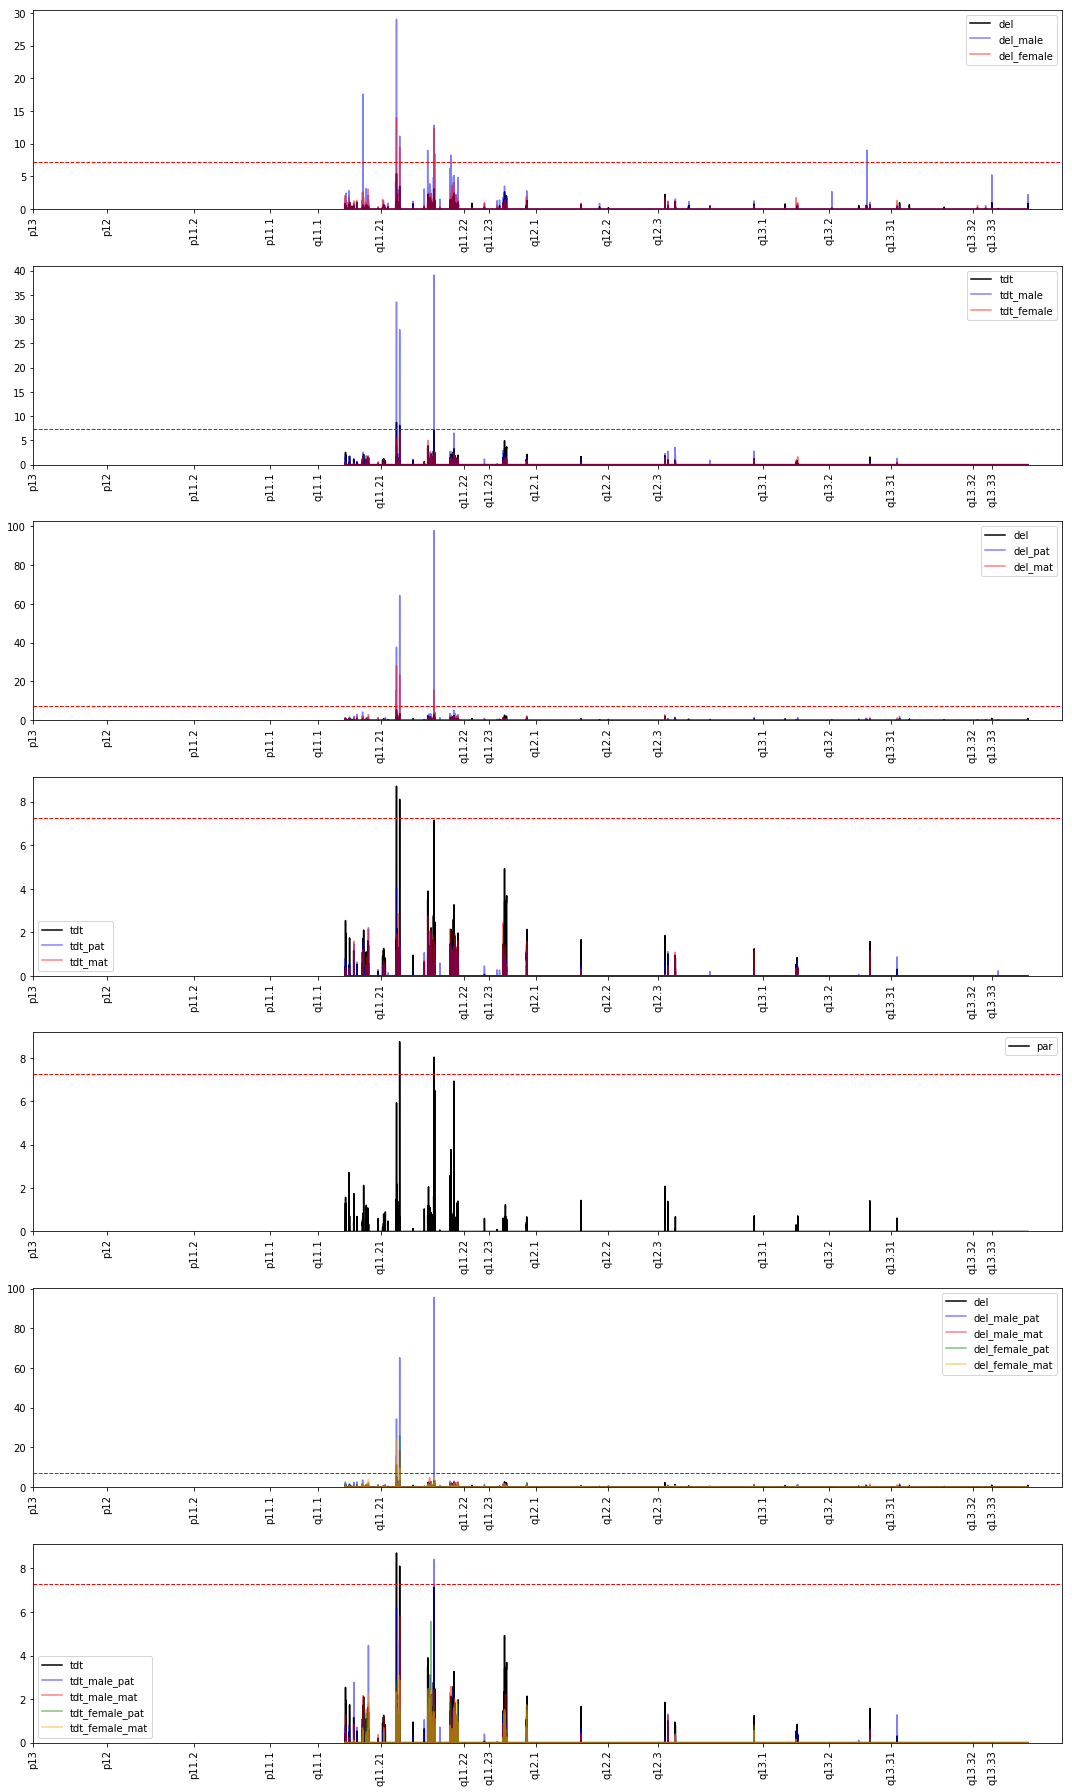

In [11]:
import matplotlib.pyplot as plt

def print_peaks(pvalues, label, comp=None):
    p = -np.log10(pvalues)
    cutoff = -np.log10(0.01/num_tests)
    hit_start_indices = np.where((p[:-1] < cutoff) & (p[1:] >= cutoff))[0]
    hit_end_indices = np.where((p[:-1] >= cutoff) & (p[1:] < cutoff))[0]
    peaks = []
    for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
        hit_start, hit_end = indices[hit_start], indices[hit_end]
        start_pos, end_pos = int(snp_positions[hit_start+1]), int(snp_positions[hit_end+1])
        cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
        peak = (int(snp_positions[hit_start+1]), int(snp_positions[hit_end+1]))
        peaks.append(peak)
        star = '*' if comp is not None and peak in comp else ''            
        print(star + label, end_pos-start_pos, start_pos, end_pos, xticklabels[cyto], sep='\t')
    return set(peaks)
np.set_printoptions(suppress=True)

# plot pvalues
plt.figure(figsize=(15, 25))

to_plot = [('del_pvalues', 'del_male_pvalues', 'del_female_pvalues'),
          ('tdt_pvalues', 'tdt_male_pvalues', 'tdt_female_pvalues'),
          ('del_pvalues', 'del_pat_pvalues', 'del_mat_pvalues'),
          ('tdt_pvalues', 'tdt_pat_pvalues', 'tdt_mat_pvalues'),
          ('par_pvalues',),
          ('del_pvalues', 'del_male_pat_pvalues', 'del_male_mat_pvalues', 'del_female_pat_pvalues', 'del_female_mat_pvalues'),
          ('tdt_pvalues', 'tdt_male_pat_pvalues', 'tdt_male_mat_pvalues', 'tdt_female_pat_pvalues', 'tdt_female_mat_pvalues')
          ]

not_par = -np.log10(par_pvalues) < 10
show_indices = [i for i in indices if not_par[i]]

for i, to_p in enumerate(to_plot):
    plt.subplot(len(to_plot), 1, i+1)
    colors = ['black', 'blue', 'red', 'green', 'orange']
    saved_peaks = None
    for j, p in enumerate(to_p):
        plt.plot(snp_positions[show_indices], -np.log10(eval(p)[show_indices]), label=p[:-8], color=colors[j], alpha=1 if colors[j] == 'black' else 0.5)

        pp = print_peaks(eval(p)[show_indices], p[:-8], comp=saved_peaks)
        if saved_peaks is None:
            saved_peaks = pp

    plt.xticks(xticks, xticklabels, rotation='vertical')
    plt.axhline(y=-np.log10(0.01/num_tests), linewidth=1, linestyle='--', color='r')
    plt.ylim(bottom=0)
    plt.legend()

plt.tight_layout()
plt.show()

In [12]:
p = -np.log10(tdt_pvalues[indices])
cutoff = 4
hit_start_indices = np.where((p[:-1] < cutoff) & (p[1:] >= cutoff))[0]
hit_end_indices = np.where((p[:-1] >= cutoff) & (p[1:] < cutoff))[0]
for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
    hit_start, hit_end = indices[hit_start], indices[hit_end]
    start_pos, end_pos = int(snp_positions[hit_start+1]), int(snp_positions[hit_end+1])
    cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
               
    print(end_pos-start_pos, start_pos, end_pos, xticklabels[cyto], sep='\t')
    
print(np.min(tdt_pvalues))

14	18718217	18718231	q11.21
592	18718670	18719262	q11.21
1	18879898	18879899	q11.21
41	18883635	18883676	q11.21
8	20657950	20657958	q11.21
497	24282784	24283281	q11.23
1.2486490851331277e-09


# Pull in other SV callers

In [16]:
sv_deletions = np.zeros((snp_positions.shape[0],), dtype=int)
with open('../other_sv_calls/Consensus_structural_calls/iHART_ms1.common_DEL_SMuFin-LUMPY-GenomeSTRiP-BreakDancer.1percent.2ormoreMethods.sorted.union.txt') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if chrom == pieces[0]:
            start_index = np.searchsorted(snp_positions, int(pieces[1]))
            end_index = np.searchsorted(snp_positions, int(pieces[2]))
            sv_deletions[start_index:end_index] += 1
    
    

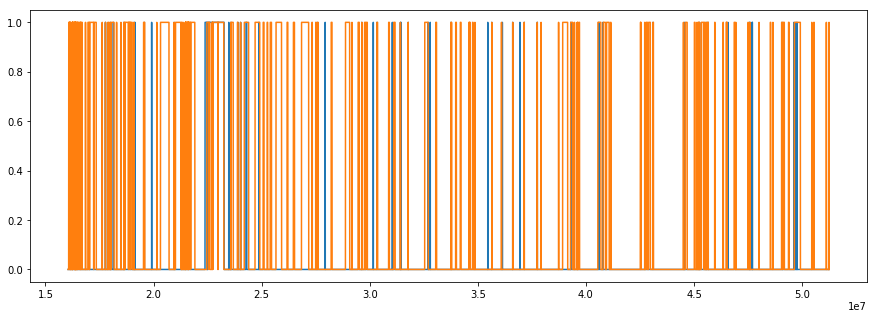

In [29]:
has_deletions = np.sum(del_conting_t[:-1, 1, :, :, :], axis=(1, 2, 3))>0
plt.figure(figsize=(15, 5))
plt.plot(snp_positions, sv_deletions)
plt.plot(snp_positions, has_deletions)
plt.show()

In [33]:
print(np.sum((sv_deletions==1) & (has_deletions==1)))
print(np.sum((sv_deletions==1) & (has_deletions==0)))
print(np.sum((sv_deletions==0) & (has_deletions==1)))
print(np.sum((sv_deletions==0) & (has_deletions==0)))

28543
10056
175517
790533


# Let's consider missing deletions
We won't be able to detect a deletion if it isn't inherited. So what fraction of the genome isn't inherited?

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


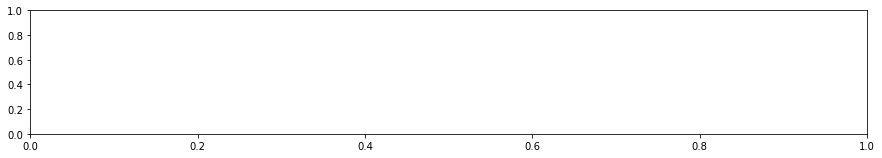

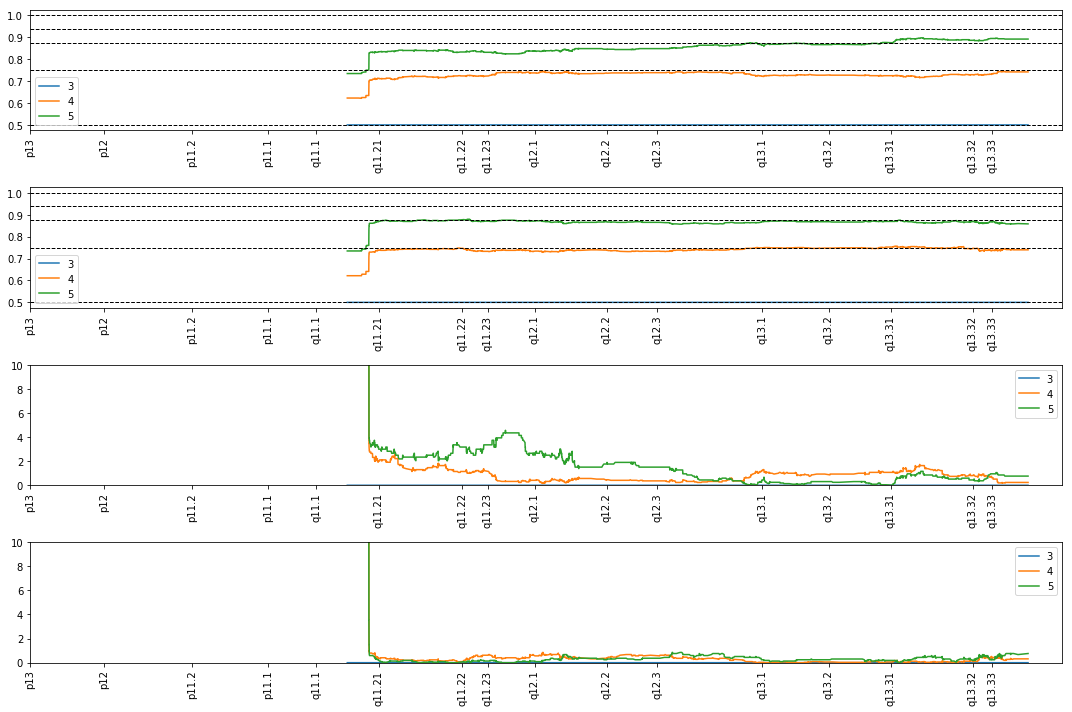

In [351]:
from scipy.stats import chisquare

plt.figure(figsize=(15, 10))
inh_ps = [0]*(max(family_sizes)+1)
inh_mat_ps = [0]*(max(family_sizes)+1)
inh_pat_ps = [0]*(max(family_sizes)+1)

for j in family_sizes:
    inherited = np.zeros((max_index+1,2), dtype=int)
    not_inherited = np.zeros((max_index+1,2), dtype=int)

    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = list(map(int, pieces[1:(1+(j*2))]))
            start_pos, end_pos = [int(x) for x in pieces[(1+(j*2)):(3+(j*2))]]
            start_index, end_index = pos_to_index[start_pos], pos_to_index[end_pos]
                            
            m1_inh, m2_inh, p1_inh, p2_inh = 0, 0, 0, 0
            for k, s in enumerate(inheritance_state[4:]):
                if k % 2 == 0:
                    m1_inh += (s==0)
                    m2_inh += (s==1)
                else:
                    p1_inh += (s==0)
                    p2_inh += (s==1)
                        
            num_mat_inherited, num_pat_inherited = (m1_inh>0) + (m2_inh>0), (p1_inh>0) + (p2_inh>0)
            inherited[start_index:(end_index+1), 0] += num_mat_inherited
            inherited[start_index:(end_index+1), 1] += num_pat_inherited
            not_inherited[start_index:(end_index+1), 0] += 2 - num_mat_inherited
            not_inherited[start_index:(end_index+1), 1] += 2 - num_pat_inherited

        plt.subplot(4, 1, 1)
        plt.plot(snp_positions[indices], (inherited[:, 0]/(inherited[:, 0]+not_inherited[:, 0]))[indices], label=str(j))
        plt.subplot(4, 1, 2)
        plt.plot(snp_positions[indices], (inherited[:, 1]/(inherited[:, 1]+not_inherited[:, 1]))[indices], label=str(j))
        
        # calc pvalues
        inh_ps[j] = np.ones((max_index+1,))
        inh_mat_ps[j] = np.ones((max_index+1,))
        inh_pat_ps[j] = np.ones((max_index+1,))
        for i in indices:
            p_not_inherited = pow(0.5, j-2)
            inh, notinh = inherited[i, 0], not_inherited[i, 0]
            total = inh+notinh
            inh_mat_ps[j][i] = chisquare([inh, notinh], [total*(1-p_not_inherited), total*p_not_inherited])[1]
            
            inh, notinh = inherited[i, 1], not_inherited[i, 1]
            total = inh+notinh
            inh_pat_ps[j][i] = chisquare([inh, notinh], [total*(1-p_not_inherited), total*p_not_inherited])[1]
            
            inh, notinh = inherited[i, 0]+inherited[i, 1], not_inherited[i, 0]+not_inherited[i, 1]
            total = inh+notinh
            inh_ps[j][i] = chisquare([inh, notinh], [total*(1-p_not_inherited), total*p_not_inherited])[1]
        
        
        plt.subplot(4, 1, 3)
        plt.plot(snp_positions[indices], -np.log10(inh_mat_ps[j][indices]), label=str(j))
        
        plt.subplot(4, 1, 4)
        plt.plot(snp_positions[indices], -np.log10(inh_pat_ps[j][indices]), label=str(j))
        
plt.subplot(4, 1, 1)
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=1, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.5, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.75, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.875, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.9375, linewidth=1, linestyle='--', color='black')
plt.legend()

plt.subplot(4, 1, 2)
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=1, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.5, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.75, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.875, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.9375, linewidth=1, linestyle='--', color='black')
plt.legend()

plt.subplot(4, 1, 3)
plt.xticks(xticks, xticklabels, rotation='vertical')
#plt.axhline(y=1, linewidth=1, linestyle='--', color='black')
plt.ylim(0, 10)
plt.legend()

plt.subplot(4, 1, 4)
plt.xticks(xticks, xticklabels, rotation='vertical')
#plt.axhline(y=1, linewidth=1, linestyle='--', color='black')
plt.ylim(0, 10)
plt.legend()

plt.tight_layout()
plt.show()

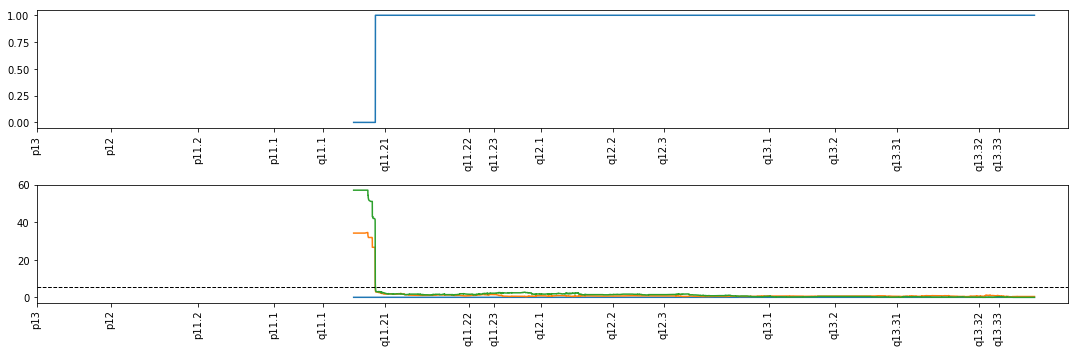

In [352]:
plt.figure(figsize=(15, 5))
# only look at regions where inheritance rate is close to expected
ok_indices = np.ones((max_index+1,), dtype=bool)
plt.subplot(2, 1, 2)
for j in family_sizes:
    ok_indices[-np.log10(inh_ps[j]) > -np.log10(0.01/indices.shape[0])] = 0
    plt.plot(snp_positions[indices], -np.log10(inh_ps[j][indices]))
ok_indices[-np.log10(par_pvalues) > -np.log10(0.01/indices.shape[0])] = 0
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=-np.log10(0.01/indices.shape[0]), linewidth=1, linestyle='--', color='black')

plt.subplot(2, 1, 1)
plt.plot(snp_positions[indices], ok_indices[indices])
plt.xticks(xticks, xticklabels, rotation='vertical')

plt.tight_layout()
plt.show()

# Check for outliers

In [43]:
next_state = [0, 0, 0, 0]
starts = [max_index+1, max_index+1, max_index+1, max_index+1]
del_start = np.zeros((max_index,))
del_end = np.zeros((max_index,))
del_intervals = []
prev_key = None
for j in family_sizes:      
    # load deletions
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [None if x == '*' else int(x) for x in pieces[1:(1+(j*2))]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(1+(j*2)):(5+(j*2))]]
            length = end_pos - start_pos + 1
            
            if len([x for x in inheritance_state[:4] if x is None]) == 0:
                if prev_key != family_key:
                    next_state = inheritance_state[:4]
                    starts = [max_index+1, max_index+1, max_index+1, max_index+1]
                    prev_key = family_key
                
                for i in range(4):
                    if inheritance_state[i] == 0 and next_state[i] == 1:
                        del_start[end_index:starts[i]] += 1
                        del_intervals.append(snp_positions[starts[i]]-snp_positions[end_index])
                       # print('start', end_index, starts[i], starts[i]-end_index)

                    elif inheritance_state[i] == 1 and next_state[i] == 0:
                        del_end[end_index:starts[i]] += 1
                        del_intervals.append(snp_positions[starts[i]]-snp_positions[end_index])
                        #print('end', end_index, starts[i], starts[i]-end_index)

                    starts[i] = start_index
                    next_state[i] = inheritance_state[i]

834.0
min length 1 max length 822049 num 4639


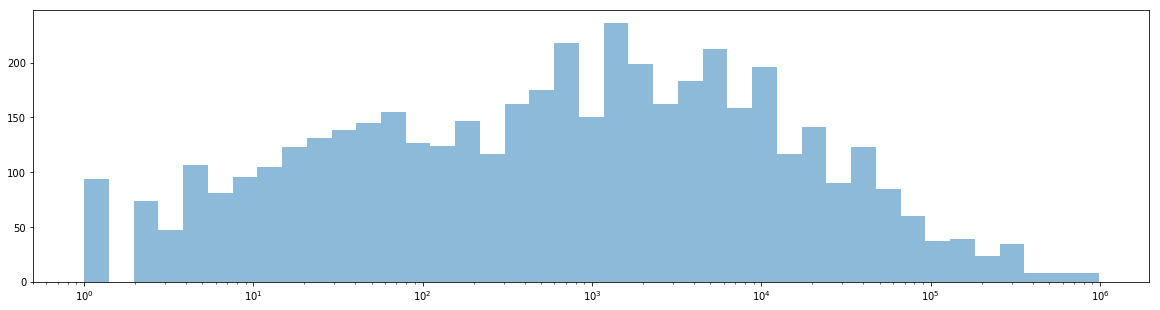

In [44]:
import math

print(np.median([x for x in del_intervals if x != 1]))

plt.figure(figsize=(20, 5))
base = 1.4
max_length = max(del_intervals) 
min_length = min(del_intervals) 
print('min length', min_length, 'max length', max_length, 'num', len(del_intervals))
plt.hist(del_intervals, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)
plt.gca().set_xscale("log")
plt.show()

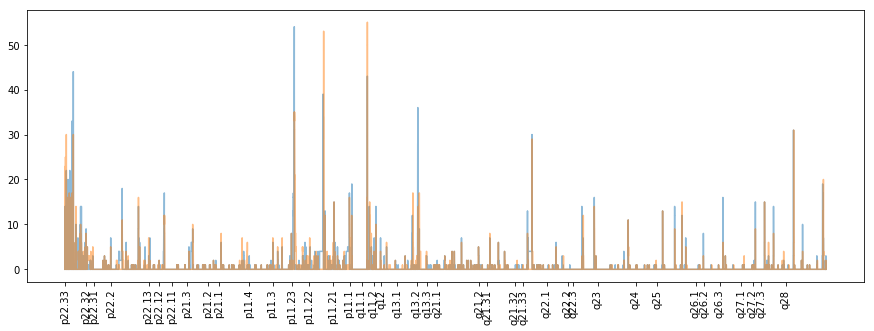

In [45]:
plt.figure(figsize=(15, 5))
plt.plot(snp_positions, del_start, alpha=0.5)
plt.plot(snp_positions, del_end, alpha=0.5)
plt.xticks(xticks, xticklabels, rotation='vertical')

plt.show()

outliers 0
[]


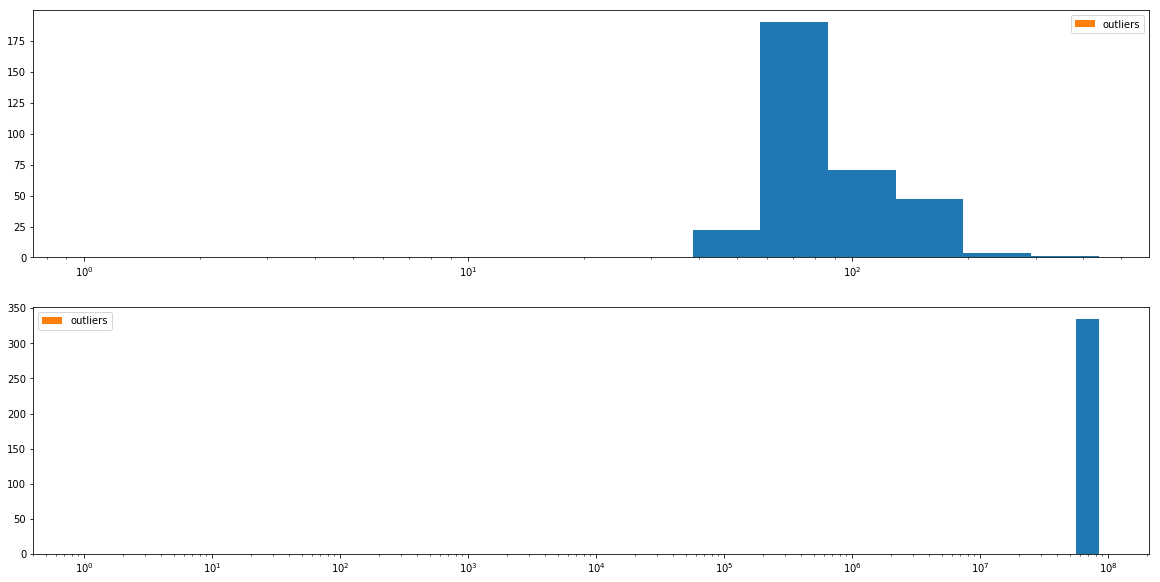

In [323]:
import math

from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import collections as mc

# deletions per family
plt.figure(figsize=(20, 10))

family_to_num_deletions = defaultdict(int)
family_to_nucleo_deleted = defaultdict(int)

for d in deletions:
    family_to_num_deletions[d.family] += 1
    family_to_nucleo_deleted[d.family] += d.length
    
outliers = [f for f in family_to_num_deletions.keys() if family_to_num_deletions[f] > 10000]
print('outliers', len(outliers))
print([(f, len(family_to_individuals[f])) for f in outliers])

base = 1.5

plt.subplot(2, 1, 1)
max_length = max(family_to_num_deletions.values()) 
bins = [pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)]
plt.hist([x for f, x in family_to_num_deletions.items() if f not in outliers], bins=bins)
plt.hist([x for f, x in family_to_num_deletions.items() if f in outliers], bins=bins, label='outliers')
plt.gca().set_xscale("log")
plt.legend()

plt.subplot(2, 1, 2)
max_length = max(family_to_nucleo_deleted.values()) 
bins = [pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)]
plt.hist([x for f, x in family_to_nucleo_deleted.items() if f not in outliers], bins=bins)
plt.hist([x for f, x in family_to_nucleo_deleted.items() if f in outliers], bins=bins, label='outliers')

plt.gca().set_xscale("log")
plt.legend()

#ax3 = plt.subplot(3, 1, 3)
#min_family = min(family_to_num_deletions.items(), key=lambda x:x[1])[0]
#max_family = max(family_to_num_deletions.items(), key=lambda x:x[1])[0]

#lines = [[(d.start_pos, 0), (d.end_pos, 0)] for d in deletions if d.family==min_family if d.chrom==4]
#lc = mc.LineCollection(lines, linewidths=12, colors='blue')
#ax3.add_collection(lc)
#ax3.autoscale()
#ax3.margins(0.1)
#lines = [[(d.start_pos, 0), (d.end_pos, 0)] for d in deletions if d.family==max_family if d.chrom==4]
#lc = mc.LineCollection(lines, linewidths=12, colors='red')
#ax3.add_collection(lc)
#ax3.autoscale()
#ax3.margins(0.1)

#plt.plot(sum([[d.start_pos, d.end_pos] for d in min_family_dels]), sum([[]]))
#plt.legend()
plt.show()

# Distribution of deletions

191044256
min length 9 max length 4092328 num 288441 num/family 331.9228998849252


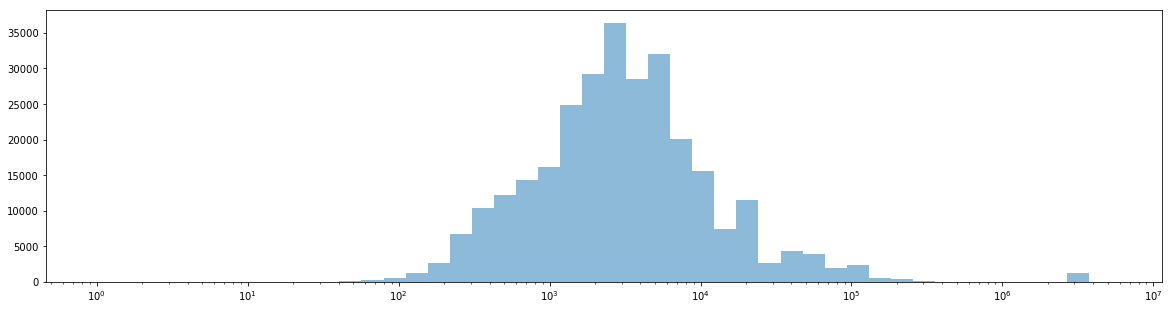

In [92]:
import math

d_length = [0, 0, 0, 0]
d_intervals = []
for j in family_sizes:
    # load deletions
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            inheritance_state = [None if x == '*' else int(x) for x in pieces[1:(1+(j*2))]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(1+(j*2)):(5+(j*2))]]
            length = end_pos - start_pos + 1

            for i in range(4):
                if inheritance_state[i] == 1:
                    d_length[i] += length
                elif d_length[i] != 0:
                    d_intervals.append(d_length[i])
                    d_length[i] = 0
for i in range(4):
    if d_length[i] != 0:
        d_intervals.append(d_length[i])
    

# length of deletions
plt.figure(figsize=(20, 5))
base = 1.4
max_length = max(d_intervals) 
min_length = min(d_intervals) 
print(snp_positions[-1])
print('min length', min_length, 'max length', max_length, 'num', len(d_intervals), 'num/family', len(d_intervals)/len(family_to_individuals))
plt.hist(d_intervals, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)
plt.gca().set_xscale("log")
plt.show()

min length 0 max length 683805


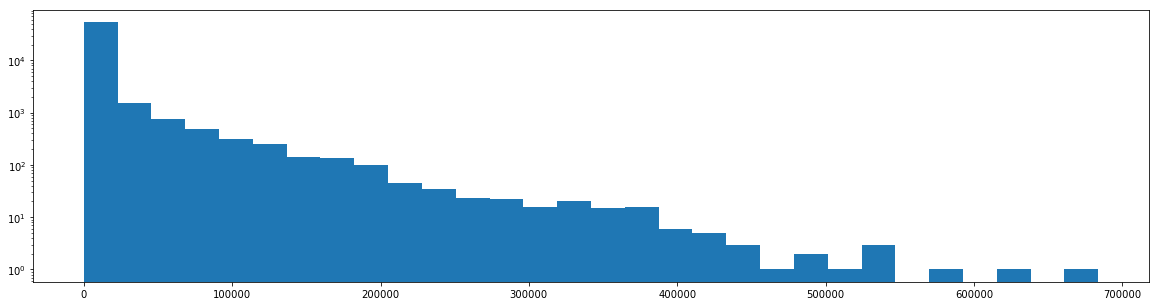

In [84]:
import math
import matplotlib.pyplot as plt

# length of deletions
plt.figure(figsize=(20, 5))
base = 1.4
max_length = max([d.end_index-d.start_index for d in deletions]) 
min_length = min([d.end_index-d.start_index for d in deletions]) 
print('min length', min_length, 'max length', max_length)
plt.hist([d.end_index-d.start_index for d in deletions], bins=30, log=True)#, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)])
#plt.gca().set_xscale("log")
plt.show()